### Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import root_scalar


### 4.7

#### a)

Let's define the region of absolute stability for the Heun method and plot this on a contour plot for different values of $h$ and $\lambda$.

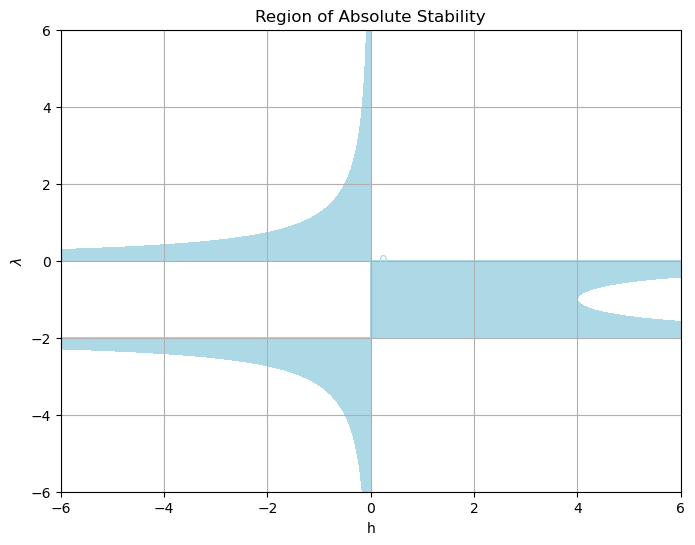

In [2]:
def heun_region(h, lam):
    return np.abs(1 + lam * h + lam**2 * h / 2)

h_vals = np.linspace(-6, 6, 400)
lam_vals = np.linspace(-6, 6, 400)

h, lam = np.meshgrid(h_vals, lam_vals)
region = heun_region(h, lam)

plt.figure(figsize=(8, 6))
c = plt.contourf(h_vals, lam_vals, region, levels=[0, 1], colors=['lightblue'])
plt.clabel(c, inline=True, fontsize=10)
plt.xlabel('h')
plt.ylabel('$\lambda$')
plt.title('Region of Absolute Stability')
plt.grid(True)
plt.show()


Now let's do the same for the Runge-Kutta with Butcher tableau as in $4.6$. The region is not given here but we can observe that $u_{n+1} = R(\lambda h)^{n+1}u_0$ so we simply need $|R(\lambda h)|<1$ for absolute stability (with $R(\lambda h)$ defined in $4.6$).

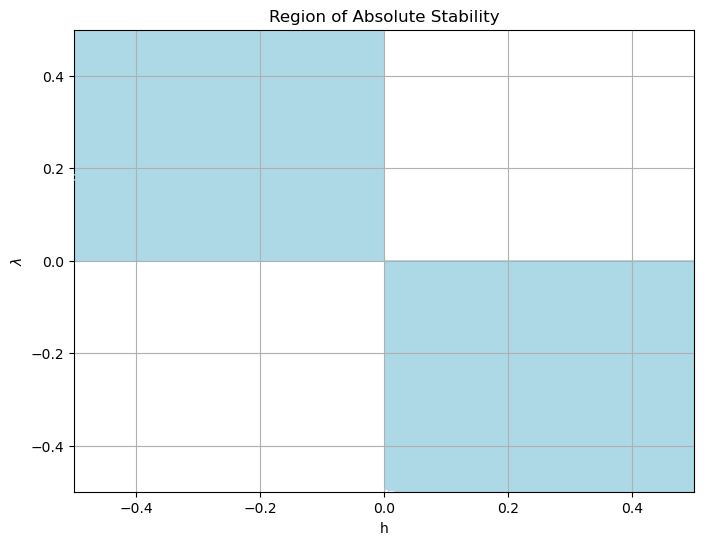

In [3]:
def rk_region(h, lam):
    num = (1 + lam * h / 2 + lam**2 * h**2 / 12)
    den = (1 - lam * h / 2 + lam**2 * h**2 / 12)
    return np.abs(num / den)

h_vals = np.linspace(-0.5, 0.5, 400)
lam_vals = np.linspace(-0.5, 0.5, 400)

h, lam = np.meshgrid(h_vals, lam_vals)
region = rk_region(h, lam)

plt.figure(figsize=(8, 6))
c = plt.contourf(h_vals, lam_vals, region, levels=[0, 1], colors=['lightblue'])
plt.clabel(c, inline=True, fontsize=10)
plt.xlabel('h')
plt.ylabel('$\lambda$')
plt.title('Region of Absolute Stability')
plt.grid(True)
plt.show()


This one is a lot more clear: we simply need exactly one of $h$ or $\lambda$ to be positive and the other to be negative.

### 4.8

#### a)

Let's redefine the evolve function as well as the forward Euler and Heun methods like in the quiz.

In [4]:
def evolve(t0, y0, f, Phi, h, N):

    u = [y0]
    t = t0
    
    for n in range(N):
        u.append(Phi(t, u[-1], f, h))
        t += h
    
    return u

def forwardEuler(t, u, f, h):
    return u + h * f(t, u)

def Heun(t, u, f, h):
    euler_estimate = u + h * f(t, u)
    return u + (h/2) * (f(t, u) + f(t + h, euler_estimate))


Now we can define the lastError function.

In [5]:
def lastError(Phi, h, N):
   
    def f(t, y):
        return -(1 + t) * y**2
    
    def y_exact(t):
        return 2 / (t**2 + 2*t + 2)
    
    t0 = 0
    y0 = y_exact(t0)
    
    u = evolve(t0, y0, f, Phi, h, N)
    y_final = y_exact(N*h)
    
    return abs(u[-1] - y_final)


#### b)

Let's also define a function to manually calculate the EOCs.

In [6]:
def EOC(hs, es):
    eocs = [np.nan]
    for i in range(1, len(hs)):
        eocs.append(np.log(es[i-1]/es[i]) / np.log(hs[i-1]/hs[i]))
    return eocs


#### c)

Now we can use our implementations from $(a)$ and $(b)$. Let's first plot the errors of the two methods for $N_02^k$ steps of size $h = \frac{T}{N_02^k}$ with $T = 1.5, N_0 = 4$

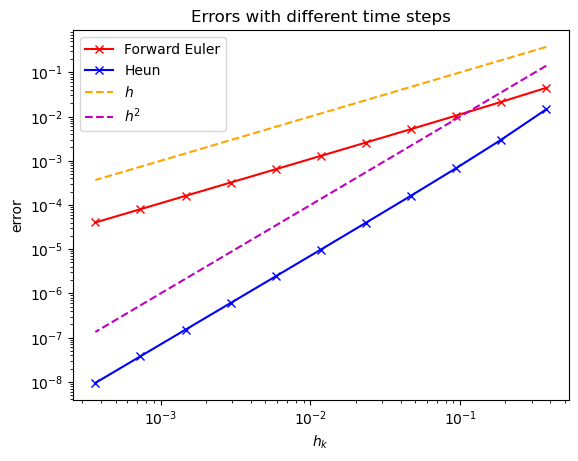

In [7]:
N0, T = 4, 1.5
N_values = np.array([N0 * 2**k for k in range(11)])
h_values = np.array([T / N for N in N_values])
forwardEuler_errors = [lastError(forwardEuler, h_values[i], N_values[i]) for i in range(11)]
Heun_errors = [lastError(Heun, h_values[i], N_values[i]) for i in range(11)]
                       
plt.plot(h_values, forwardEuler_errors, 'x-r', label='Forward Euler')
plt.plot(h_values, Heun_errors, 'x-b', label='Heun')
plt.plot(h_values, h_values, '--', color='orange', label='$h$')
plt.plot(h_values, h_values**2, 'm--', label='$h^2$')
plt.xscale('log')
plt.yscale('log')
plt.title('Errors with different time steps')
plt.xlabel('$h_k$')
plt.ylabel('error')
plt.legend()
plt.show()


As we can see Forward Euler is parallel to $h$ and Heun is parallel to $h^2$ which shows that they are of order 1 and 2 respectively. We can also display the EOC values using the function we defined in $(b)$ to verify this computationally.

In [8]:
df_eocs = pd.DataFrame({
    'Time intervals': h_values,
    'Forward Euler': EOC(h_values, forwardEuler_errors),
    'Heun': EOC(h_values, Heun_errors)
})

display(df_eocs)


,Time intervals,Forward Euler,Heun
0,0.375000,NaN,NaN
1,0.187500,1.057627,2.284387
2,0.093750,1.029500,2.138402
3,0.046875,1.014779,2.066564
4,0.023438,1.007381,2.032547
5,0.011719,1.003687,2.016085
6,0.005859,1.001842,2.007995
7,0.002930,1.000921,2.003986
8,0.001465,1.000460,2.001990
9,0.000732,1.000230,2.000994


Which confirms the error scaling.

### 4.9

#### a)

With our assumption of $A$ being of lower triangular and 0 diagonal, we have the following:

$$K_1 = f(t_n + c_1h, u_n)$$
$$K_2 = f(t_n + c_2h, u_n + ha_{21}K_1)$$
$$K_3 = f(t_n + c_3h, u_n + h(a_{31}K_1 + a_{32}K_2)$$

and so on. Hence we can implement our increment function now:

In [9]:
def explicitRK(t, u, f, h, A, b, c):
    
    s = len(b)
    K_vals = []
    
    for i in range(s):
        K = f(t + h * c[i], u + h * np.dot(A[i][:i], K_vals[:i]))
        K_vals.append(K)
        
    phi = np.dot(b, K_vals)
    return u + h * phi


Now we can use this for the given methods. Let's define some wrapper functions for ease of implementation.

In [10]:
def forward_euler(t, u, f, h):
    A = [[0]]
    b = [1]
    c = [0]
    return explicitRK(t, u, f, h, A, b, c)

def explicit_midpoint(t, u, f, h):
    A = [[0,0], [1/2,0]]
    b = [0, 1]
    c = [0, 1/2]
    return explicitRK(t, u, f, h, A, b, c)

def RK3(t, u, f, h):
    A = [[0,0,0], [1/2,0,0], [-1,2,0]]
    b = [1/6, 2/3, 1/6]
    c = [0, 1/2, 1]
    return explicitRK(t, u, f, h, A, b, c)


And now we can plot the errors of the three methods on a log-log plot.

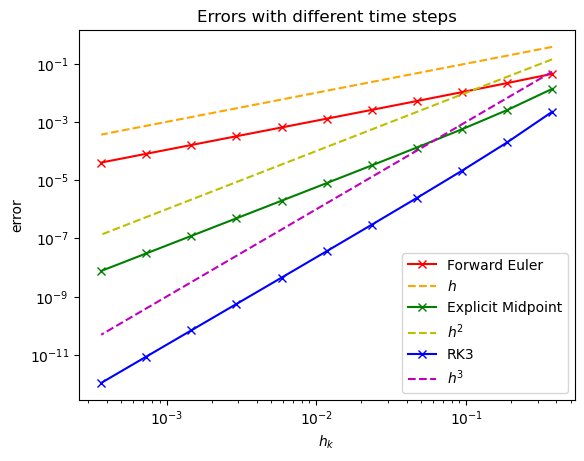

In [11]:
plt.plot(h_values, [lastError(forward_euler, h_values[i], N_values[i]) for i in range(11)], 'x-r', label='Forward Euler')
plt.plot(h_values, h_values, '--', color='orange', label='$h$')
plt.plot(h_values, [lastError(explicit_midpoint, h_values[i], N_values[i]) for i in range(11)], 'x-g', label='Explicit Midpoint')
plt.plot(h_values, h_values**2, '--y', label='$h^2$')
plt.plot(h_values, [lastError(RK3, h_values[i], N_values[i]) for i in range(11)], 'x-b', label='RK3')
plt.plot(h_values, h_values**3, '--m', label='$h^3$')
plt.xscale('log')
plt.yscale('log')
plt.title('Errors with different time steps')
plt.xlabel('$h_k$')
plt.ylabel('error')
plt.legend()
plt.show()


This shows how the errors of the forward Euler, explicit midpoint and RK3 methods scale with order 1, 2 and 3 respectively as we would expect. This is equivalent to the number of stages too.

#### b)

In [12]:
def DIRK(t, u, f, h, A, b, c):
    
    s = len(b)
    K_vals = []
    
    F = lambda x: x - f(t + h * c[i], u + h * np.dot(A[i][:i], K_vals[:i]) + h * A[i][i] * x)
    
    for i in range(s):
        K = root_scalar(F, x0=f(t,u), x1=2*f(t,u)).root  
        K_vals.append(K)
        
    phi = np.dot(b, K_vals)
    return u + h * phi


Let's again define wrapper functions for the given DIRK methods.

In [13]:
def implicit_midpoint(t, u, f, h):
    A = [[1/2]]
    b = [1]
    c = [1/2]
    return DIRK(t, u, f, h, A, b, c)

def crouzeix(t, u, f, h):
    A = [[1/2 + np.sqrt(3)/6, 0], [-np.sqrt(3)/3, 1/2 + np.sqrt(3)/6]]
    b = [1/2, 1/2]
    c = [1/2 + np.sqrt(3)/6, 1/2 - np.sqrt(3)/6]
    return DIRK(t, u, f, h, A, b, c)


And now we can plot the errors of these two implicit methods.

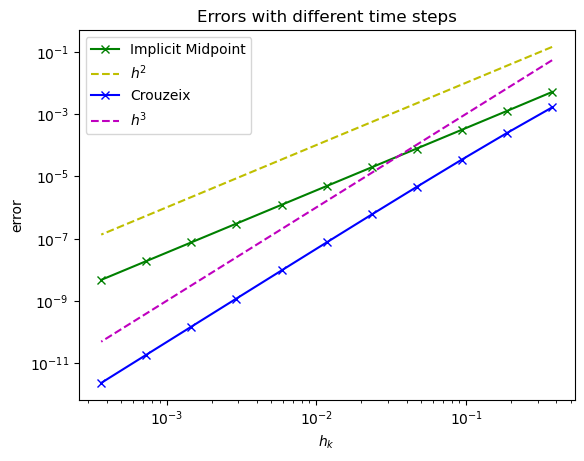

In [14]:
plt.plot(h_values, [lastError(implicit_midpoint, h_values[i], N_values[i]) for i in range(11)], 'x-g', label='Implicit Midpoint')
plt.plot(h_values, h_values**2, '--y', label='$h^2$')
plt.plot(h_values, [lastError(crouzeix, h_values[i], N_values[i]) for i in range(11)], 'x-b', label='Crouzeix')
plt.plot(h_values, h_values**3, '--m', label='$h^3$')
plt.xscale('log')
plt.yscale('log')
plt.title('Errors with different time steps')
plt.xlabel('$h_k$')
plt.ylabel('error')
plt.legend()
plt.show()


As before, we have plotted lines for $y=h^\gamma$ to compare slopes. This plot verifies that the orders of the implicit midpoint and Crouzeix methods are 2 and 3 respectively.